## 7.1 从语言模型到循环神经网络

In [10]:
import torch
import torch.nn.functional as F

##计算Ht，假设激活函数为ReLU。
X, W_xh = torch.normal( 0, 1,(2, 3)), torch.normal( 0, 1,(3, 4))
H, W_hh = torch.normal( 0, 1,(2, 4)), torch.normal( 0, 1,(4, 4))
B_h= torch.normal( 0, 1,(1, 4))
H1=torch.matmul(X, W_xh) + torch.matmul(H, W_hh)+B_h
H_t=F.relu(H1)

##计算O_t，输出激活函数为softmax
W_hm=torch.normal( 0, 1,(4, 2))
B_m= torch.normal( 0, 1,(1, 2))
O=torch.matmul(H_t, W_hm) +B_m
O_t=F.softmax(O,dim=-1)
print("H_t的形状：{}，O_t的形状：{}".format(H_t.shape,O_t.shape))


H_t的形状：torch.Size([2, 4])，O_t的形状：torch.Size([2, 2])


In [12]:
H01=torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0)) + B_h
H02=F.relu(H01)
###查看矩阵H_t和H02
print("-"*30+"矩阵H_t"+"-"*30)
print(H_t)
print("-"*30+"矩阵H02"+"-"*30)
print(H02)


------------------------------矩阵H_t------------------------------
tensor([[0.0000, 0.0000, 0.0825, 1.8822],
        [0.2298, 0.0000, 0.0000, 0.0000]])
------------------------------矩阵H02------------------------------
tensor([[0.0000, 0.0000, 0.0825, 1.8822],
        [0.2298, 0.0000, 0.0000, 0.0000]])


## 7.2前向传播与随时间反向传播

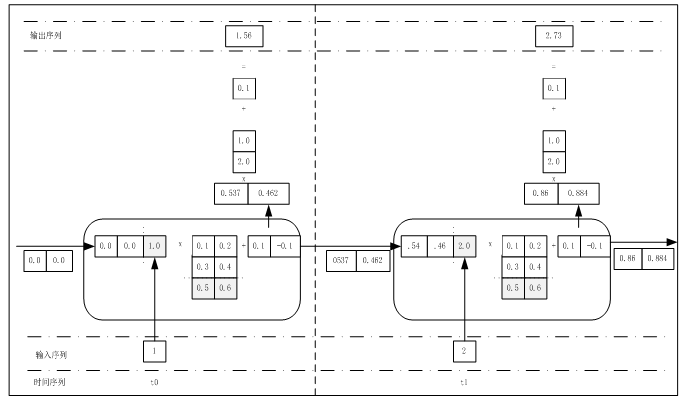

In [2]:
import numpy as np

X = [1,2]
state = [0.0, 0.0]
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4],[0.5, 0.6]])
b_cell = np.asarray([0.1, -0.1])
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

for i in range(len(X)):
    state=np.append(state,X[i])
    before_activation = np.dot(state, w_cell_state) + b_cell
    state = np.tanh(before_activation)
    final_output = np.dot(state, w_output) + b_output
    print("状态值_%i: "%i, state)
    print("输出值_%i: "%i, final_output)


状态值_0:  [0.53704957 0.46211716]
输出值_0:  [1.56128388]
状态值_1:  [0.85973818 0.88366641]
输出值_1:  [2.72707101]


## 7.4 循环神经网络的Pytorch实现
前面我们介绍了循环神经网络的基本架构及其LSTM、GRU等变种。针对这些循环神经网络，PyTorch均提供了相应的API，如单元版的有nn.RNNCell、nn.LSTMCell、nn.GRUCell等，封装版的有nn.RNN、nn.LSTM、nn.GRU。单元版与封装版的最大区别在于输入，前者的输入是时间步或序列的一个元素，后者的输入是一个时间步序列。利用这些API可以极大提高我们的开发效率。

### 7.4.1 使用PyTorch实现RNN
	PyTorch为RNN提供了两个版本的循环神经网络接口，单元版的输入是每个时间步或循环神经网络的一个循环，而封装版的输入是一个序列。下面我们从简单的封装版torch.nn.RNN开始，其一般格式为：
torch.nn.RNN( args, * kwargs)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

为使大家对循环神经网络有个直观理解，下面先用PyTorch实现简单循环神经网络，然后验证其关键要素。
	首先建立一个简单循环神经网络，输入维度为10，隐含状态维度为20，单向两层网络。

In [2]:
rnn = nn.RNN(input_size=10, hidden_size=20,num_layers= 2)

因输入节点与隐含层节点是全连接，根据输入维度、隐含层维度，可以推算出相关权重参数的维度，w_ih应该是20x10，w_hh是20x20, b_ih和b_hh都是hidden_size。下面我们通过查询weight_ih_l0、weight_hh_l0等进行验证。

In [3]:
#第一层相关权重参数形状
print("wih形状{},whh形状{},bih形状{}".format(rnn.weight_ih_l0.shape,rnn.weight_hh_l0.shape,rnn.bias_hh_l0.shape))
#wih形状torch.Size([20, 10]),whh形状torch.Size([20, 20]),bih形状#torch.Size([20])
#第二层相关权重参数形状
print("wih形状{},whh形状{},bih形状{}".format(rnn.weight_ih_l1.shape,rnn.weight_hh_l1.shape,rnn.bias_hh_l1.shape))
# wih形状torch.Size([20, 20]),whh形状torch.Size([20, 20]),bih形状#torch.Size([20])

wih形状torch.Size([20, 10]),whh形状torch.Size([20, 20]),bih形状torch.Size([20])
wih形状torch.Size([20, 20]),whh形状torch.Size([20, 20]),bih形状torch.Size([20])


RNN已搭建好，接下来将输入(x_t 、h_0)传入网络，根据网络配置及网络要求，生成输入数据。输入特征长度为100，批量大小为32，特征维度为10的张量。按网络要求，隐含状态的形状为(2,32,20)。

In [4]:
#生成输入数据
input=torch.randn(100,32,10)
h_0=torch.randn(2,32,20)

将输入数据传入RNN，将得到输出及更新后的隐含状态值。根据以上规则，输出output的形状应该是（100,32,20），隐含状态的输出的形状应该与输入的形状一致。

In [5]:
output,h_n=rnn(input,h_0)
print(output.shape,h_n.shape)
#torch.Size([100, 32, 20]) torch.Size([2, 32, 20])

torch.Size([100, 32, 20]) torch.Size([2, 32, 20])


结果与我们设想的完全一致。
	RNNCell的输入的形状是(batch,input_size)，没有序列长度，这是因为隐含状态的输入只有单层，故其形状为(batch,hdden_size)。网络的输出只有隐含状态输出，其形状与输入一致，即(batch,hdden_size)。
	接下来我们利用PyTorch实现RNN，RNN由全连接层来构建，每一步输出预测和隐含状态，先前的隐含状态输入至下一时刻，具体如图7-12所示。
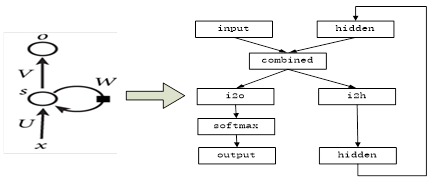
<center>图7-12 RNN架构</center>
图7-12所示架构是一个典型的RNN架构，我们将用PyTorch实现该网络。

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#rnn = RNN(n_letters, n_hidden, n_categories)

### 7.4.2 使用PyTorch实现LSTM
	LSTM是在RNN基础上增加了长时间记忆功能，具体通过增加一个状态C及3个门实现对信息的更精准控制。具体实现可参考图7-9。
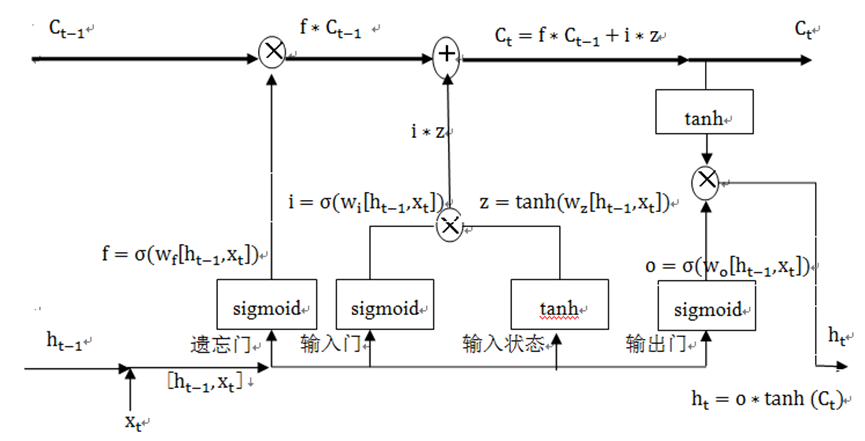
<center>图7-9  LSTM 架构图</center>

In [7]:
import torch.nn as nn
import torch

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, cell_size, output_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.cell_size = cell_size
        self.gate = nn.Linear(input_size + hidden_size, cell_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        f_gate = self.sigmoid(self.gate(combined))
        i_gate = self.sigmoid(self.gate(combined))
        o_gate = self.sigmoid(self.gate(combined))
        z_state = self.tanh(self.gate(combined))
        cell = torch.add(torch.mul(cell, f_gate), torch.mul(z_state, i_gate))
        hidden = torch.mul(self.tanh(cell), o_gate)
        output = self.output(hidden)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, self.cell_size)

### 7.4.3 使用PyTorch实现GRU
从图7-10可知，GRU架构与LSTM架构基本相同，主要区别是LSTM共有3个门，2个隐含状态；而GRU只有2个门，1个隐含状态。GRU的参数个数是标准RNN的3倍。
 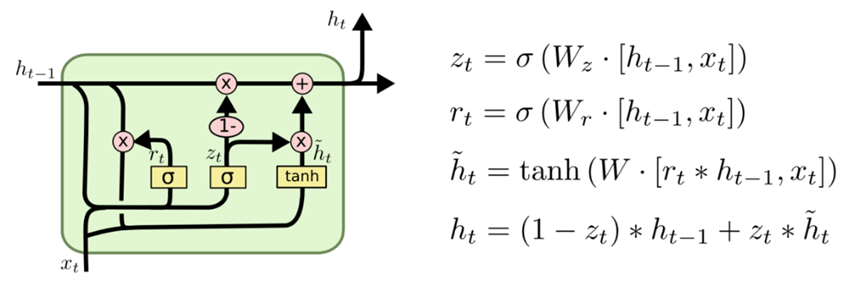
 <center>图7-10 GRU架构，其中小圆圈表示向量的点积</center>
用PyTorch实现GRU单元与实现LSTM单元的方法类似，具体代码如下：

In [8]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)        
        z_gate = self.sigmoid(self.gate(combined))
        r_gate = self.sigmoid(self.gate(combined))
        combined01 = torch.cat((input, torch.mul(hidden,r_gate)), 1)  
        h1_state = self.tanh(self.gate(combined01))
        
        h_state = torch.add(torch.mul((1-z_gate), hidden), torch.mul(h1_state, z_gate))
        output = self.output(h_state)
        output = self.softmax(output)
        return output, h_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)    

In [9]:
grucell = GRUCell(input_size=10,hidden_size=20,output_size=10)

In [10]:
import torch.nn as nn

In [11]:
grucell = GRUCell(input_size=10,hidden_size=20,output_size=10)

In [12]:
input=torch.randn(32,10)
h_0=torch.randn(32,20)

output,hn=grucell(input,h_0)
print(output.size(),hn.size())

torch.Size([32, 10]) torch.Size([32, 20])
